In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB ? eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.1 (from versions: 0.1.6, 0.2.0, 0.15.0+cu117, 0.15.1+cu117, 0.15.2+cu117)
ERROR: No matching distribution found for torchvision==0.14.1


In [ ]:
!pip install torch==1.13.1

In [ ]:
!pip install "numpy==1.23.5" "thinc==8.3.4" "monai==1.2.0" "nibabel==4.0.2"
#"torchvision==0.14.1" "torchaudio==0.13.1"

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached thinc-8.3.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached monai-1.2.0-202306081546-py3-none-any.whl.metadata (10 kB)
  Using cached nibabel-4.0.2-py3-none-any.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Kotina/model/
root_path = '/content/drive/My Drive/Kotina/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Kotina/model


In [ ]:
# !python -c "import monai" #|| pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    DivisiblePadd,
    RandAffined,
    RandRotated,
    RandGaussianNoised,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from datetime import datetime

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# import zipfile
# import shutil

# # 1. Переименовываем (если нужно)
# original_path = "/content/drive/My Drive/kaggle_ds/unet3dAdamwDicece_20_augm.h5"
# new_path = "/content/drive/My Drive/kaggle_ds/unet3dAdamwDicece_20_augm.zip"
# shutil.move(original_path, new_path)

# # 2. Распаковываем
# with zipfile.ZipFile(new_path, 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/My Drive/kaggle_ds/extracted")

In [ ]:
# !ls "/content/drive/My Drive/kaggle_ds/extracted/unet3dAdamwDicece_20_augm"

data  data.pkl	version


In [ ]:
model_path = "/content/drive/My Drive/kaggle_ds/extracted/unet3dAdamwDicece_20_augm/data.pkl"

In [ ]:
import torch
import pickle
from monai.networks.nets import UNet

class SafeUnpickler(pickle.Unpickler):
    def persistent_load(self, saved_id):
        if saved_id[0] == 'storage':
            return torch.Storage()
        return saved_id

def load_checkpoint_safely(path):
    with open(path, 'rb') as f:
        unpickler = SafeUnpickler(f)
        return unpickler.load()

checkpoint = load_checkpoint_safely(model_path)

<ipython-input-25-93af1c4a9909>:9: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return torch.Storage()  # Заглушка для storage


In [ ]:
print("Тип checkpoint:", type(checkpoint))
if isinstance(checkpoint, dict):
    print("Ключи:", checkpoint.keys())

Тип checkpoint: <class 'monai.networks.nets.unet.UNet'>


In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1, # hard labeling
    out_channels=2, # soft labeling
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout =0.2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
elif isinstance(checkpoint, dict):
    model.load_state_dict(checkpoint)
else:
    model = checkpoint

model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [ ]:
data_dir = "/content/drive/My Drive/kaggle_ds/"
train_images = sorted(glob.glob(os.path.join(data_dir, "Train", "*/*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "Train_labels", "*/*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-4], data_dicts[-4:] # 16 train and 4 validation
# train_files, val_files

In [ ]:
from monai.transforms import (Transposed, CenterSpatialCropd, SpatialPadd, AddChanneld, EnsureTyped)
import numpy as np

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        # Transposed(keys=["image", "label"], indices = (2,0,1)),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16),
    EnsureTyped(keys=["image", "label"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        # Transposed(keys=["image", "label"], indices = (2,0,1)),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16),
    EnsureTyped(keys=["image", "label"])
    ]
)

augm_transforms = Compose(
    [
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=(10.0, 10.0, 10.0)),
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=np.pi/12),
        RandGaussianNoised(keys='image', prob=0.5),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
# 2 images -> transform
train_ds = CacheDataset(data=train_files, transform=train_transforms)

# # transform + data augmentation
augm_ds= CacheDataset(data=train_files, transform=[train_transforms, augm_transforms])

train_ds = ConcatDataset([train_ds, augm_ds])

train_loader = DataLoader(train_ds)

val_ds = CacheDataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds)

Loading dataset: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


In [ ]:
print(next(model.parameters()).device)

cuda:0


In [ ]:
images = []
outputs = []
labels = []
for val_data in val_loader:
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model(val_inputs))
    labels.append(val_labels)

In [ ]:
# Assuming outputs, labels, and images are your variables
output = outputs[0]
label = labels[0][0][0]
image = images[0][0][0]

# Set the slice range from 45 to 50
slice_start = 45
slice_end = 50

# Calculate the number of slices
num_slices = slice_end - slice_start

# Create a subplot with 'num_slices' rows and 3 columns
plt.figure(figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Increment the slice index
    current_slice = slice_start + i

    # Plot the Model Output
    plt.subplot(num_slices, 3, 3 * i + 1)
    with torch.no_grad():
        plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
    plt.title(f'Model Output - Slice {current_slice}')

    # Plot the Label
    plt.subplot(num_slices, 3, 3 * i + 2)
    plt.imshow(label.cpu()[:, :, current_slice])
    plt.title(f'Label - Slice {current_slice}')

    # Plot the Input Image
    plt.subplot(num_slices, 3, 3 * i + 3)
    plt.imshow(image.cpu()[:, :, current_slice])
    plt.title(f'Input Image - Slice {current_slice}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


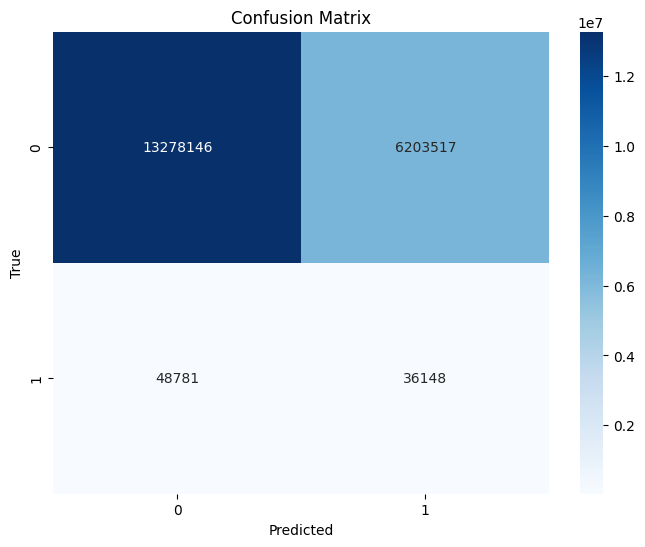

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

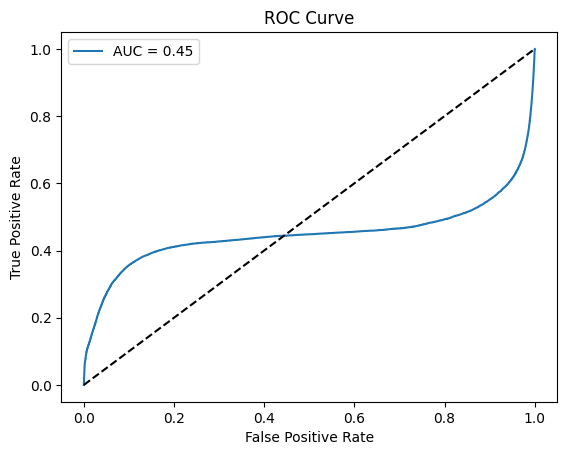

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy().flatten()
y_true = labels.cpu().numpy().flatten()

fpr, tpr, thresholds = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()